<a href="https://colab.research.google.com/github/hazanyucel/Medikal-Goruntu-Isleme-medical-image-processing-/blob/main/ACDCMedikal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 1. Gerekli kütüphaneleri kuralım
!pip install segmentation-models
!pip install nibabel

import os
# Segmentation Models için framework ayarını importtan ÖNCE yapıyoruz
os.environ['SM_FRAMEWORK'] = 'tf.keras'

import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import h5py # .h5 dosyaları için
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Segmentation Models kütüphanesi
import segmentation_models as sm
sm.framework()

print("Kütüphaneler yüklendi ve U-Net++ için ortam hazır.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 5.2 MB/s eta 0:00:00
Segmentation Models: using `tf.keras` framework.
Kütüphaneler yüklendi ve U-Net++ için ortam hazır.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

def load_acdc_data_h5(base_path, img_size=(128, 128)):
    images = []
    masks = []

    print(f"Veriler okunuyor: {base_path} ...")

    # Klasörleri gez
    for root, dirs, files in os.walk(base_path):
        for file in files:
            # .h5 uzantılı dosyaları bul
            if file.endswith('.h5'):
                file_path = os.path.join(root, file)
                try:
                    with h5py.File(file_path, 'r') as f:
                        if 'image' in f and 'label' in f:
                            img_slice = f['image'][:]
                            mask_slice = f['label'][:]

                            # Boş (sadece siyah) maskeleri alma
                            if np.sum(mask_slice) > 0:
                                # Yeniden Boyutlandırma
                                img_slice = cv2.resize(img_slice, img_size, interpolation=cv2.INTER_LINEAR)
                                mask_slice = cv2.resize(mask_slice, img_size, interpolation=cv2.INTER_NEAREST)

                                images.append(img_slice)
                                masks.append(mask_slice)
                except Exception as e:
                    print(f"Hata oluştu {file_path}: {e}")

    images = np.array(images)
    masks = np.array(masks)

    # Normalizasyon ve Boyut Ayarlama
    if images.size > 0:
        images = (images - np.min(images)) / (np.max(images) - np.min(images) + 1e-8)
        # (Batch, 128, 128, 1) -> (Batch, 128, 128, 3) RGB formatına çevirme
        images = np.expand_dims(images, axis=-1)
        images = np.repeat(images, 3, axis=-1)

        # Maskeleri One-Hot Encoding yap
        masks = to_categorical(masks, num_classes=4)
    else:
        print("Uyarı: Hiç görüntü yüklenemedi!")

    return images, masks

# --- AYARLAR ---
# Senin paylaştığın .h5 dosyalarının olduğu yol:
path_to_dataset = '/content/drive/MyDrive/Medgoris/archive/ACDC_preprocessed/ACDC_training_slices'
IMG_SIZE = (128, 128)
CLASSES = 4

# Veriyi Yükle
X, y = load_acdc_data_h5(path_to_dataset, img_size=IMG_SIZE)

# Eğitim ve Test Ayrımı
if X.size > 0:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print(f"Eğitim Verisi: {X_train.shape}")
    print(f"Test Verisi: {X_test.shape}")
else:
    print("Veri yüklenemedi, lütfen yolu kontrol et.")

Mounted at /content/drive
Veriler okunuyor: /content/drive/MyDrive/Medgoris/archive/ACDC_preprocessed/ACDC_training_slices ...
Eğitim Verisi: (1480, 128, 128, 3)
Test Verisi: (370, 128, 128, 3)


In [4]:
# --- Metrik Fonksiyonu ---
def dice_coef(y_true, y_pred):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1.0) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + 1.0)

# Eğitim Parametreleri
BATCH_SIZE = 16
EPOCHS = 30
LR = 0.0001

print("--- Model: U-Net (ResNet34) Hazırlanıyor ---")

# MODEL TANIMI: U-Net
# segmentation_models kütüphanesinde UnetPlusPlus doğrudan bulunmamaktadır (versiyon 1.0.1 için).
# Bunun yerine standart U-Net modeli kullanılacaktır.
# ResNet34 backbone'u ve ImageNet ağırlıkları ile
model_unet_plus = sm.Unet('resnet34', classes=CLASSES, activation='softmax', encoder_weights='imagenet')

# Compile
model_unet_plus.compile(
    optimizer=tf.keras.optimizers.Adam(LR),
    loss=sm.losses.DiceLoss() + sm.losses.CategoricalFocalLoss(),
    metrics=[dice_coef, sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5), 'accuracy']
)

# Eğitim Başlat
history_unet_plus = model_unet_plus.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_test, y_test),
    verbose=1
)

print("U-Net Eğitimi Tamamlandı.")

--- Model: U-Net (ResNet34) Hazırlanıyor ---
85521592/85521592 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 97s 481ms/step - accuracy: 0.3542 - dice_coef: 0.2801 - f1-score: 0.1470 - iou_score: 0.0889 - loss: 0.9366 - val_accuracy: 0.9597 - val_dice_coef: 0.4746 - val_f1-score: 0.1388 - val_iou_score: 0.0961 - val_loss: 0.8350
Epoch 2/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 11s 122ms/step - accuracy: 0.9010 - dice_coef: 0.5843 - f1-score: 0.6476 - iou_score: 0.4984 - loss: 0.7429 - val_accuracy: 0.9600 - val_dice_coef: 0.6732 - val_f1-score: 0.2408 - val_iou_score: 0.2322 - val_loss: 0.7802
Epoch 3/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 11s 120ms/step - accuracy: 0.9769 - dice_coef: 0.7573 - f1-score: 0.8168 - iou_score: 0.7112 - loss: 0.6204 - val_accuracy: 0.9602 - val_dice_coef: 0.8332 - val_f1-score: 0.2448 - val_iou_score: 0.2397 - val_loss: 0.7587
Epoch 4/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 11s 121ms/step - accuracy: 0.9854 - dice_coef: 0.8961 - f1-score: 0.8595 - iou_score: 0.7

--- U-Net++ (ResNet34) Modeli İçin 5 Rastgele Örnek ---


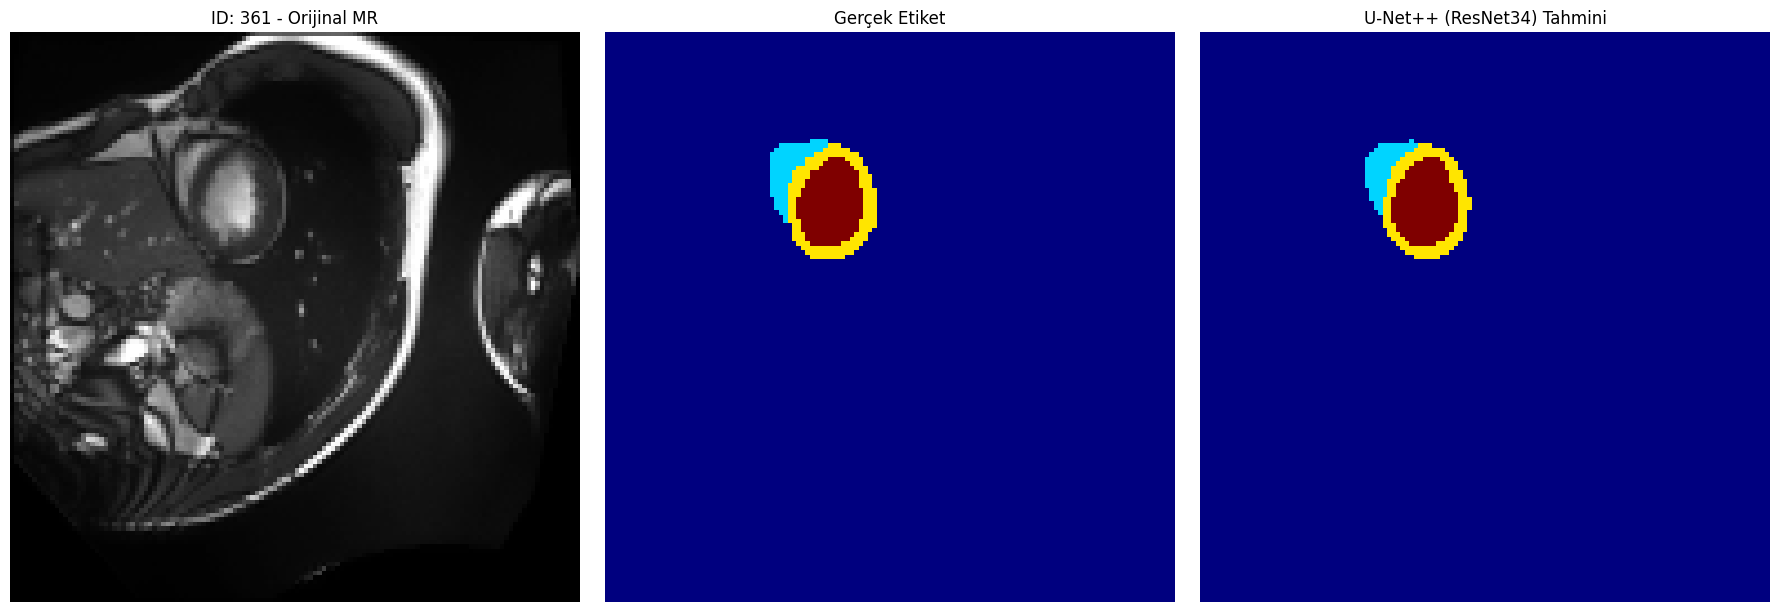

--------------------------------------------------------------------------------


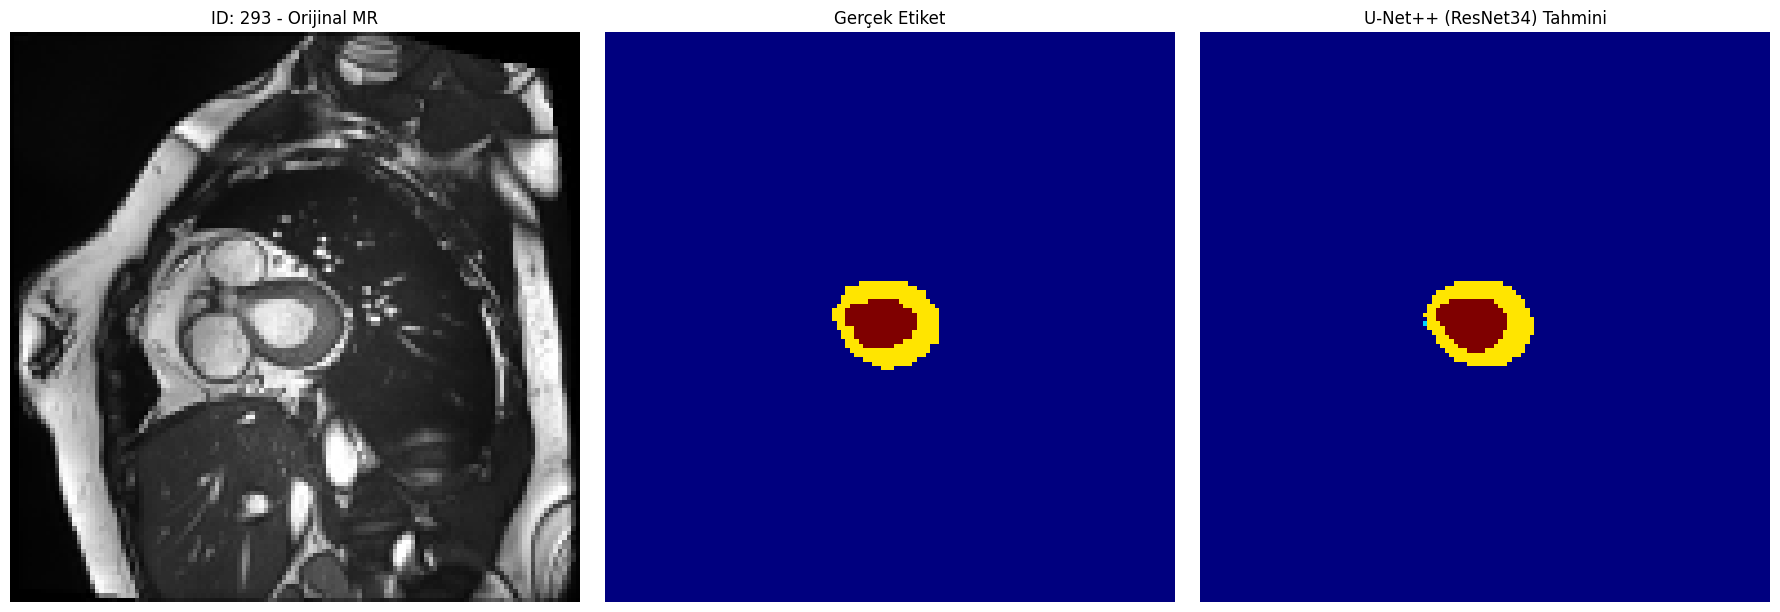

--------------------------------------------------------------------------------


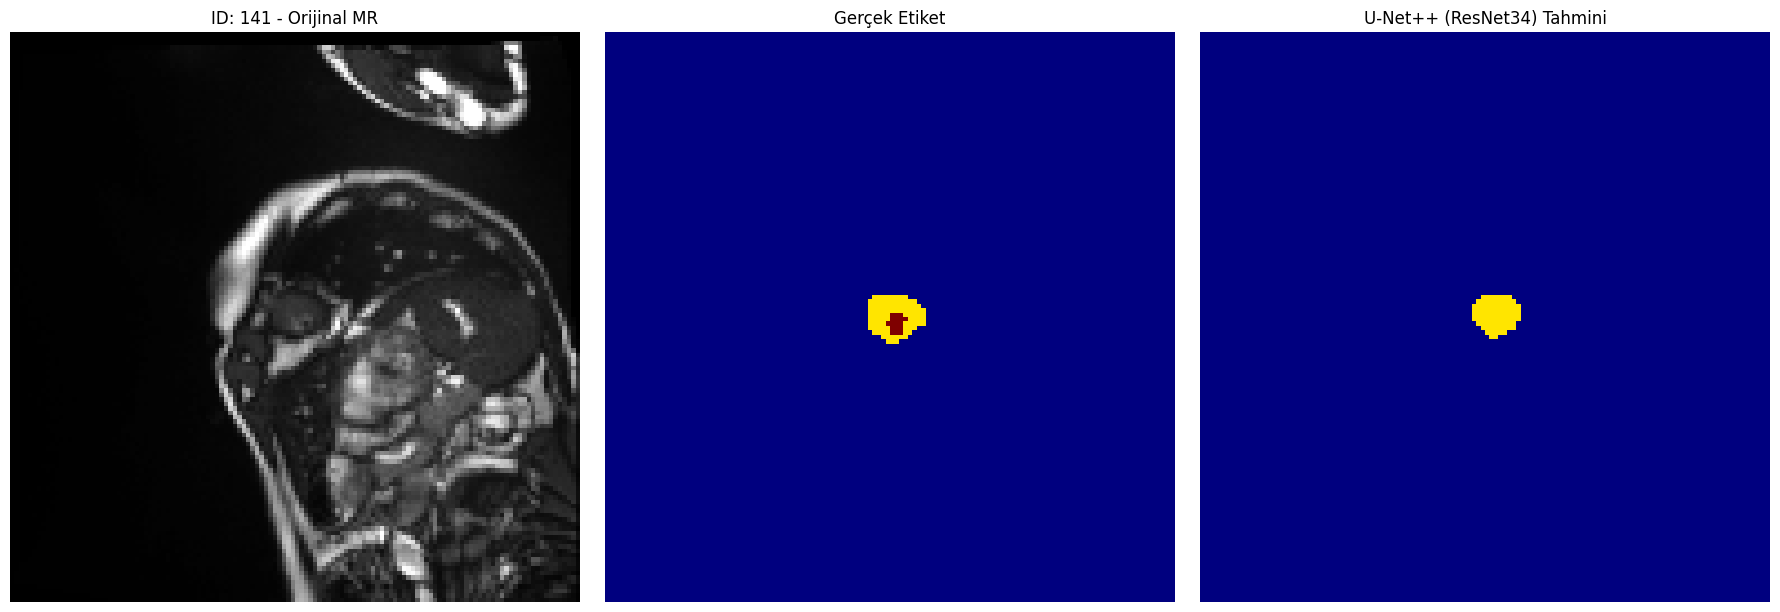

--------------------------------------------------------------------------------


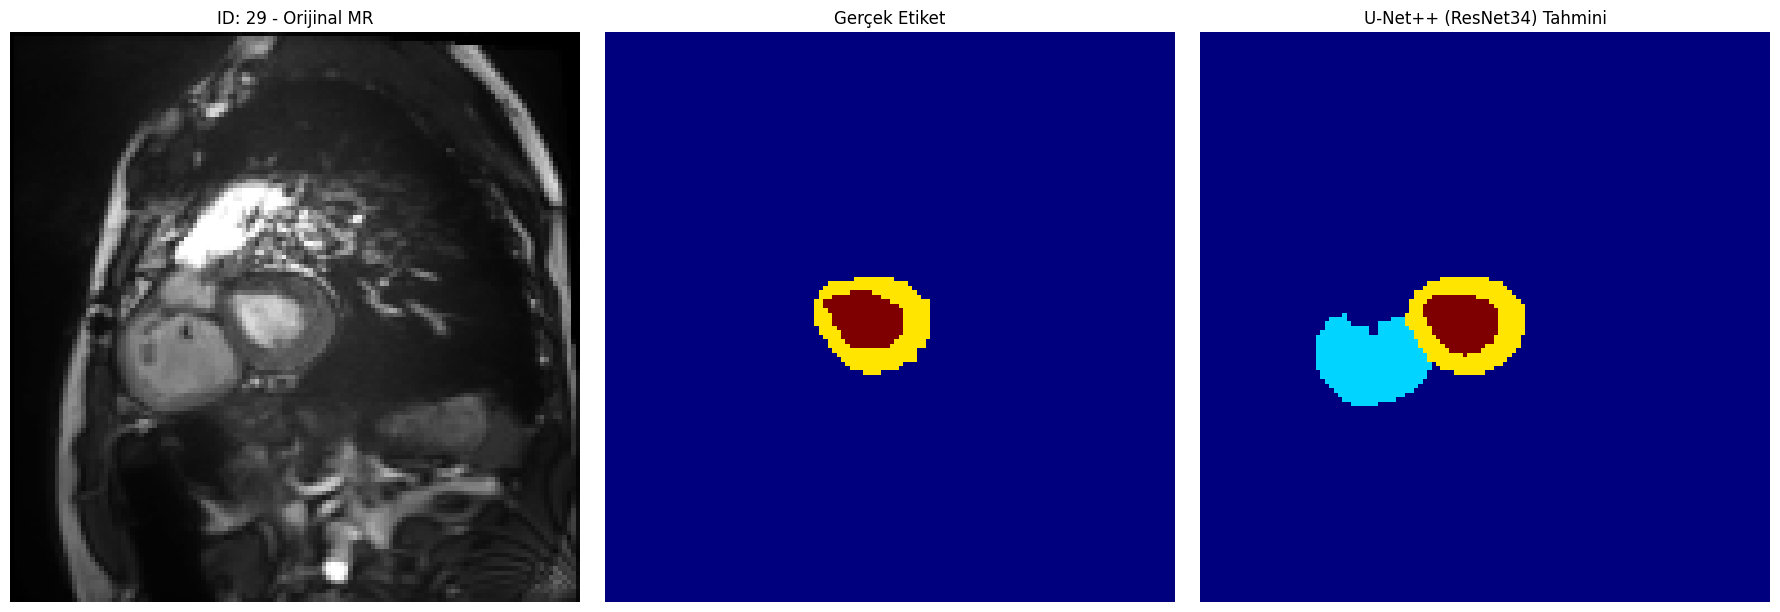

--------------------------------------------------------------------------------


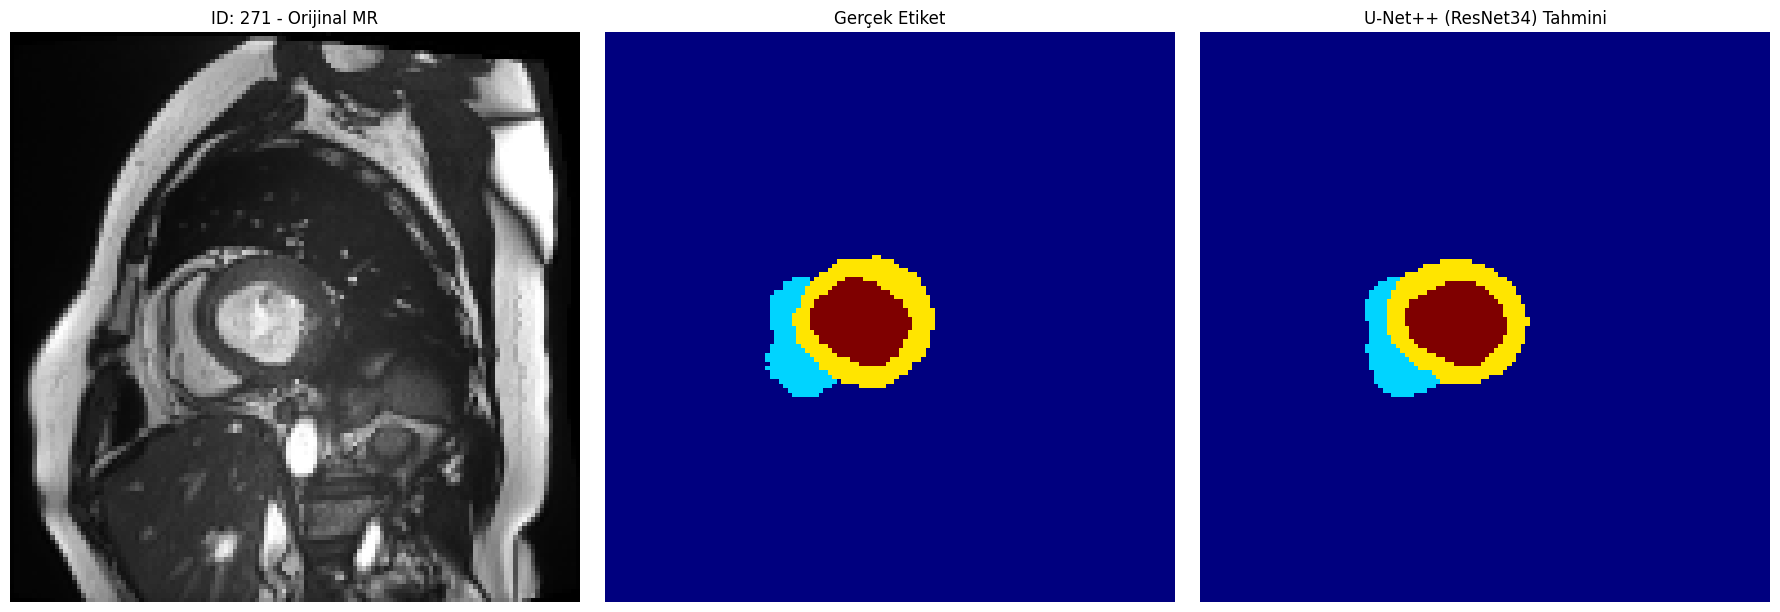

--------------------------------------------------------------------------------


In [5]:
import random

def visualize_model_predictions(model, model_name, X_test, y_test, num_samples=4):
    indices = random.sample(range(len(X_test)), num_samples)
    print(f"--- {model_name} Modeli İçin {num_samples} Rastgele Örnek ---")

    for i, idx in enumerate(indices):
        test_img = X_test[idx]
        ground_truth = np.argmax(y_test[idx], axis=-1)

        # Tahmin
        prediction_raw = model.predict(np.expand_dims(test_img, axis=0), verbose=0)
        prediction_mask = np.argmax(prediction_raw, axis=-1)[0]

        plt.figure(figsize=(18, 6))

        # 1. Orijinal
        plt.subplot(1, 3, 1)
        plt.imshow(test_img[:,:,0], cmap='gray')
        plt.title(f"ID: {idx} - Orijinal MR")
        plt.axis('off')

        # 2. Gerçek Maske
        plt.subplot(1, 3, 2)
        plt.imshow(ground_truth, cmap='jet', vmin=0, vmax=CLASSES-1)
        plt.title("Gerçek Etiket")
        plt.axis('off')

        # 3. Model Tahmini
        plt.subplot(1, 3, 3)
        plt.imshow(prediction_mask, cmap='jet', vmin=0, vmax=CLASSES-1)
        plt.title(f"{model_name} Tahmini")
        plt.axis('off')

        plt.tight_layout()
        plt.show()
        print("-" * 80)

# U-Net++ Sonuçlarını Çizdir
visualize_model_predictions(model_unet_plus, "U-Net++ (ResNet34)", X_test, y_test, num_samples=5)